# Machine Learning in the Real World

##                1.Data preparation and cleaning

## Import Python Libraries

In [279]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.cm
import pathlib
import csv
import math
import matplotlib.pyplot as plt

## Defining Data Paths And Variables

In [230]:
# Data paths
path_train = 'working_data/train_data.csv'
path_test = 'working_data/test_data.csv'
path_complete_data = 'merged_data_ready/merged_data.csv'
paths = []
paths.append('raw_data\DB_Data\Jobs.csv')
paths.append('raw_data\DB_Data\Global_Financial_Development_Data_2.csv')
paths_fixed = []
paths_fixed.append('raw_data\DB_Data\Job_fixed.csv')
paths_fixed.append('raw_data\DB_Data\Global_Financial_Development_Data_2_fixed.csv')
input_labels = 'raw_data\Labels\Happy_Planet_Index_Data'

# Paths for the graphical map visualization use
countries_codes = 'raw_data/DB_Data/WDI_Country.csv'
shapefile = 'map_files/ne_10m_admin_0_countries'
template_image = 'map_files/imgfile.png'
globe_plots = 'globe_plots/'
uncorrolated_plots = 'uncorrolated_images/'

# Years with labels
rellevant_years_for_labels = ['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',\
                              '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2009', '2012', '2016']
rellevant_years = [year + '.00' for year in rellevant_years_for_labels]

## Functions For Obtaining Data




### Merge the data with the labels

In [18]:
def mergeDataWithLabels(working_frame, labels):
    result = pd.merge(working_frame, labels, how='inner', on=['country', 'year'])
    result.to_csv(path_complete_data)

### Cleaning the CSV Files Out From Commas

In [19]:
def cleanCommasFromCSV(path_old, path_new):
    with open(path_old, "r", newline="") as infile, open(path_new, "w", newline="") as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        for row in reader:
            writer.writerow(item.replace(",", "") for item in row)

### Obtain The Labeled Data

In [20]:
def getDataFrameForLabelCSV(path, year):
    df = pd.read_csv(path, skiprows=0, usecols=[1, 8])
    df.loc[:, 'year'] = pd.Series(float(rellevant_years[rellevant_years_for_labels.index(year)]), index=df.index)
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    df.drop(df.index[[0]])
    return df

### Take Data From DataSets

In [21]:
def extractDataFromCSV(paths, path_downloaded):
    l = []
    for path in paths:
        # first, drop irrelevant years
        df = pd.read_csv(path, header=None, skiprows=0, encoding='iso-8859-1', low_memory=False)
        df.loc[0, 0] = 'country'
        df.columns = df.loc[0]
        column_years = df.columns[2:]
        years_to_drop = [y for y in column_years if y not in rellevant_years]
        df.drop(years_to_drop, axis=1, inplace=True)

        # re-pivot the data and reindex
        df = pd.pivot_table(df, index='country', columns='Series Name', aggfunc=lambda x: ' '.join(x))
        df = df.stack(level=0)
        df.reset_index(inplace=True)
        df.rename(columns={0: 'year'}, inplace=True)
        df.rename(columns={"Series Name": 'series'}, inplace=True)
        df.to_csv(path_downloaded)
        df = pd.read_csv(path_downloaded, encoding='iso-8859-1', low_memory=False)
        df.drop(df.columns[[0]], axis=1, inplace=True)
        l.append(df)
    data_df = l[0]
    for i in range(1,len(l)):
        data_df = data_df.merge(l[i], how='outer')
    data_df.replace('..', np.nan, inplace=True)
    data_df = data_df.dropna(axis=1, how='all')
    data_df = data_df[data_df.country != 'country']
    data_df = data_df.T.drop_duplicates().T
    #data_df.to_csv(path_downloaded)
    return data_df

### The Main Data Extract Function

In [22]:
def obtainDataFromLocalDBs():
    # extract the labels dataframe from the csv files
    lis = []
    for year in rellevant_years_for_labels:
        path = input_labels + '_' + year + '.csv'
        path = pathlib.Path(path)
        df = getDataFrameForLabelCSV(path, year)
        lis.append(df)
    labels_df = pd.concat(lis)

    # extract all the data dataframe from the csv files
    for i in range(len(paths)):
        cleanCommasFromCSV(paths[i], paths_fixed[i])
    df = extractDataFromCSV(paths_fixed, path_complete_data)

    # merge (by inner join) the data with the labels
    mergeDataWithLabels(df, labels_df)

### Run to Extract Data (run is needed just once)

In [26]:
obtainDataFromLocalDBs()

## Graphical representation on globus map

### For viewing map graphics, you should install 2 libraries:

#### 1. Install Basemap:
        · To install this package with conda run, type:
          conda install -c conda-forge basemap=1.0.8.dev0
        · download package and install from: http://matplotlib.org/basemap/
#### 2. Install GeonamesCache:
        · To install this package with conda run, type:
          conda install -c mbonix geonamescache=0.20
        · download package and install from: https://pypi.python.org/pypi/geonamescache
          look for version 0.20

In [254]:
import matplotlib.cm
import matplotlib as mpl
from geonamescache import GeonamesCache
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

def plotDataOnMap(data, year = 'mean', feature = "Happy Planet Index"):    
    num_colors = 9
    cols = ['country', feature]
    splitted = feature.split()
    title = feature + ' rate per country'
    imgfile = globe_plots + feature + '_'+ year + '.png'

    descripton = '''
    Expected values of the {} rate of countriers. Countries without data are shown in grey.
    Data: World Bank - worldbank.org • Lables: HappyPlanetIndex - happyplanetindex.org'''.format(feature)

    gc = GeonamesCache()
    iso3_codes = list(gc.get_dataset_by_key(gc.get_countries(), 'iso3').keys())
    df = pd.read_csv(countries_codes, skiprows=0, usecols=[0, 1], encoding='iso-8859-1')
    data_map = pd.merge(df, data, how='inner', on=['country'])
    if year == 'mean':
        data_map = data_map[['Country Code', 'country', feature]]
        data_map = data_map.groupby(['Country Code'], sort=False).mean()
    else:
        data_map = data_map[['Country Code', 'year', 'country', feature]]
        data_map = data_map.loc[data_map['year'] == float(year)]
        data_map = data_map[['Country Code', 'country', feature]]
        data_map = data_map.groupby(['Country Code'], sort=False).first()
    data_map.reset_index(inplace=True)
    values = data_map[feature]
    data_map.set_index('Country Code', inplace=True)
    cm = plt.get_cmap('Greens')
    scheme = [cm(i / num_colors) for i in range(num_colors)]
    bins = np.linspace(values.min(), values.max(), num_colors)
    data_map['bin'] = np.digitize(values, bins) - 1
    data_map.sort_values('bin', ascending=False).head(10)
    fig = plt.figure(figsize=(22, 12))

    ax = fig.add_subplot(111, axisbg='w', frame_on=False)
    if year == 'mean':
        fig.suptitle('mean {} rate for all data'.format(' '.join(splitted[:7]), year), fontsize=30, y=.95)
    else:
        fig.suptitle('{} rate in year {}'.format(' '.join(splitted[:7]), year), fontsize=30, y=.95)
    m = Basemap(lon_0=0, projection='robin')
    m.drawmapboundary(color='w')

    m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)
    for info, shape in zip(m.units_info, m.units):
        iso3 = info['ADM0_A3']
        if iso3 not in data_map.index:
            color = '#dddddd'
        else:
            ind = data_map.ix[iso3, 'bin'].astype(np.int64)
            color = scheme[ind]

        patches = [Polygon(np.array(shape), True)]
        pc = PatchCollection(patches)
        pc.set_facecolor(color)
        ax.add_collection(pc)

    # Cover up Antarctica so legend can be placed over it.
    ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

    # Draw color legend.
    ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)
    cmap = mpl.colors.ListedColormap(scheme)
    cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
    cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

    # Set the map footer.
    plt.annotate(descripton, xy=(-.8, -3.2), size=14, xycoords='axes fraction')
    plt.savefig(imgfile, bbox_inches='tight', pad_inches=.2)
    plt.plot()

## Images comparison method

### For images map comparison, you should install opencv library
        · To install this package with conda run, type:
          conda install -c conda-forge basemap=1.0.8.dev0
        · download package and install from: http://matplotlib.org/basemap/

In [248]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

def plotUncorrolatedCountries(im1, im2, output):
    img1 = cv2.imread(im1, 1)
    img2 = cv2.imread(im2, 1)
    null_img = cv2.imread(template_image, 1)
    
    img1 = cv2.cvtColor( img1, cv2.COLOR_BGR2GRAY  )
    img2 = cv2.cvtColor( img2, cv2.COLOR_BGR2GRAY  )
    null_img = cv2.cvtColor( null_img, cv2.COLOR_BGR2GRAY  )
    
    height1, width1 = img1.shape
    height2, width2 = img2.shape
    height3, width3 = null_img.shape
    
    min_h = min(height1, height2, height3)
    min_w = min(width1, width2, width3)
    
    img1 = img1[:min_h, :min_w]
    img2 = img2[:min_h, :min_w]
    null_img = null_img[:min_h, :min_w]

    crop_img = cv2.subtract(img1, img2)[65:900, :]

    null_img = null_img[65:900, :]
    thresh = (255-crop_img)
    
    cv2.addWeighted(thresh, 0.5, null_img, 0.5, 0, thresh)
    (threshold, thresh) = cv2.threshold(thresh, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    flag = cv2.imwrite(output, thresh)
    plt.axis('off')
    plt.imshow(thresh, cmap = 'gray', interpolation = 'bicubic'),plt.show()

## Reading the Working Dataset

In [233]:
overall_data = pd.read_csv(path_complete_data, header=0, index_col=0, skiprows=0, encoding='iso-8859-1')
overall_data.head(10)

country    year  Access to electricity (% of population)  \
0  Afghanistan  2012.0                                     43.0   
1  Afghanistan  2016.0                                     43.0   
2      Albania  2006.0                                      NaN   
3      Albania  2006.0                                      NaN   
4      Albania  2009.0                                      NaN   
5      Albania  2012.0                                    100.0   
6      Albania  2012.0                                      NaN   
7      Albania  2016.0                                    100.0   
8      Algeria  2006.0                                      NaN   
9      Algeria  2006.0                                      NaN   

   Adolescent fertility rate (births per 1000 women ages 15-19)  \
0                                              87.79              
1                                              76.73              
2                                              18.73              
3                                                NaN              
4                                              19.48              
5                                              20.80              
6                                                NaN              
7                                              21.49              
8                                               9.69              
9                                                NaN              

   Age dependency ratio (% of working-age population)  \
0                                              95.31    
1                                              89.77    
2                                              52.15    
3                                                NaN    
4                                              48.64    
5                                              45.84    
6                                                NaN    
7                                              44.91    
8                                              50.40    
9                                                NaN    

   Agriculture value added (% of GDP)  \
0                               24.60   
1                               23.97   
2                               22.00   
3                                 NaN   
4                               19.41   
5                               21.83   
6                                 NaN   
7                               22.67   
8                                7.75   
9                                 NaN   

   Agriculture value added (annual % growth)  \
0                                      18.22   
1                                       1.90   
2                                       3.10   
3                                        NaN   
4                                       1.90   
5                                       5.41   
6                                        NaN   
7                                       1.98   
8                                       8.10   
9                                        NaN   

   Agriculture value added (constant 2005 US$)  \
0                                 2.645462e+09   
1                                 2.689738e+09   
2                                 1.693547e+09   
3                                          NaN   
4                                 1.897705e+09   
5                                 2.256162e+09   
6                                          NaN   
7                                 2.317571e+09   
8                                 8.580218e+09   
9                                          NaN   

   Agriculture value added per worker (constant 2005 US$)  \
0                                             413.03        
1                                             395.78        
2                                            2696.73        
3                                                NaN        
4                                            3065.76        
5    

## Drop  columns with %(nulls)>90%

In [280]:
nulls_stat=np.sum(overall_data.isnull()) / (overall_data.shape[0]) * 100
problem_cols=overall_data.columns[nulls_stat > 90]

# Drop problematic columns
n_calls_old=overall_data.shape[1]
for col in problem_cols:
    overall_data = overall_data.drop(col, 1)
overall_data.head(5)

year  Access to electricity (% of population)  \
0  2012.0                                     43.0   
1  2016.0                                     43.0   
2  2006.0                                     99.7   
3  2006.0                                     99.7   
4  2009.0                                     99.7   

   Adolescent fertility rate (births per 1000 women ages 15-19)  \
0                                              87.79              
1                                              76.73              
2                                              18.73              
3                                              20.92              
4                                              19.48              

   Age dependency ratio (% of working-age population)  \
0                                              95.31    
1                                              89.77    
2                                              52.15    
3                                              51.26    
4                                              48.64    

   Agriculture value added (% of GDP)  \
0                               24.60   
1                               23.97   
2                               22.00   
3                                4.60   
4                               19.41   

   Agriculture value added (annual % growth)  \
0                                      18.22   
1                                       1.90   
2                                       3.10   
3                                       2.30   
4                                       1.90   

   Agriculture value added (constant 2005 US$)  \
0                                 2.645462e+09   
1                                 2.689738e+09   
2                                 1.693547e+09   
3                                 3.860272e+09   
4                                 1.897705e+09   

   Agriculture value added per worker (constant 2005 US$)  \
0                                            413.030        
1                                            395.780        
2                                           2696.730        
3                                           7712.345        
4                                           3065.760        

   Air transport registered carrier departures worldwide  \
0                                           17775.00       
1                                           25389.38       
2                                            4481.00       
3                                           93600.00       
4                                            5140.00       

   CPIA economic management cluster average (1=low to 6=high)  \
0                                               3.00            
1                                               3.00            
2                                               4.00            
3                                               3.67            
4                                               3.67            

         ...         country_Ukraine  country_United Arab Emirates  \
0        ...                     0.0                           0.0   
1        ...                     0.0                           0.0   
2        ...                     0.0                           0.0   
3        ...                     0.0                           0.0   
4        ...                     0.0                           0.0   

   country_United Kingdom  country_United States  country_Uruguay  \
0                     0.0                    0.0              0.0   
1                     0.0                    0.0              0.0   
2                     0.0                    0.0              0.0   
3                     0.0                    0.0              0.0   
4                     0.0                    0.0              0.0   

   country_Uzbekistan  country_Vanuatu  country_Vietnam  country_Zambia  \
0                 0.0              0.0              0.0            

## Nations tuples count- maybe we will remove some countries before running model

In [235]:
overall_data['country'].value_counts()

Netherlands                       38
Germany                           34
United Kingdom                    34
Ireland                           33
Iceland                           33
Greece                            33
Australia                         32
Belgium                           32
Sweden                            31
Luxembourg                        30
Spain                             24
Italy                             24
Mexico                            23
Japan                             22
France                            22
Finland                           22
Switzerland                       21
Austria                           19
Canada                            19
Portugal                          18
New Zealand                       18
Norway                            17
Denmark                           17
Romania                           12
Bulgaria                          12
Brazil                            10
Slovenia                           8
C

## Years tuples histogram- maybe we will remove some years before running model

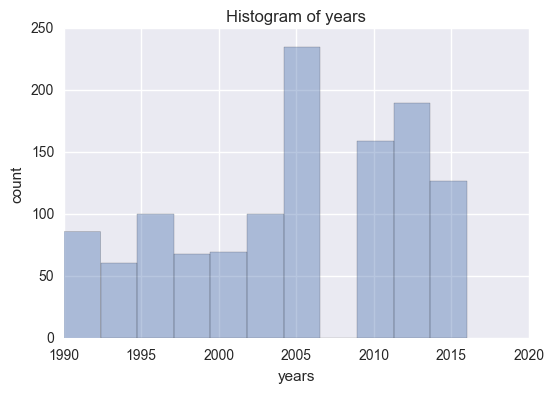

In [236]:
%matplotlib inline
sns.distplot(overall_data['year'], kde = False)
plt.title('Histogram of years')
plt.xlabel('years')
plt.ylabel('count')
plt.show()

### Histogram of Happy Planet Index values

C:\Users\Avi\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


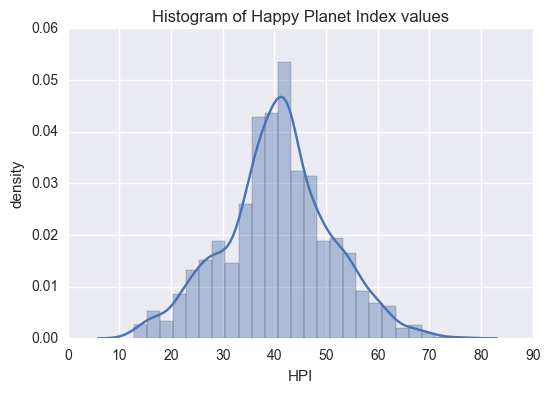

In [237]:
%matplotlib inline
sns.distplot(overall_data['Happy Planet Index'], bins = 25, kde = True)
plt.title('Histogram of Happy Planet Index values')
plt.xlabel('HPI')
plt.ylabel('density')
plt.show()

## Find Most Corrolated features

In [242]:
THRESHOLD = 0.4
data_corr_mat= overall_data.corr(method='spearman')
HPI_correlation = pd.DataFrame(data_corr_mat[data_corr_mat.columns[len(data_corr_mat.columns)-1]])
HPI_pos_correlation = HPI_correlation[HPI_correlation[HPI_correlation.columns[len(HPI_correlation.columns)-1]] > \
                                      THRESHOLD]
HPI_neg_correlation = HPI_correlation[HPI_correlation[HPI_correlation.columns[len(HPI_correlation.columns)-1]] < \
                                      (THRESHOLD*(-1))]
HPI_relevant_correlation = HPI_pos_correlation.append(HPI_neg_correlation)
HPI_relevant_correlation.sort_values(inplace=True, by=['Happy Planet Index'], ascending=False)
HPI_relevant_correlation = HPI_relevant_correlation[HPI_relevant_correlation['Happy Planet Index']<1]
HPI_relevant_correlation.to_csv("Rcorr.csv", sep=',', encoding='utf-8')
print(HPI_relevant_correlation)

                                                    Happy Planet Index
Daily newspapers (per 1000 people)                            0.506649
Bank accounts per 1000 adults                                 0.402361
Prevalence of HIV total (% of population ages 1...           -0.417042


## Print Covariance matrix

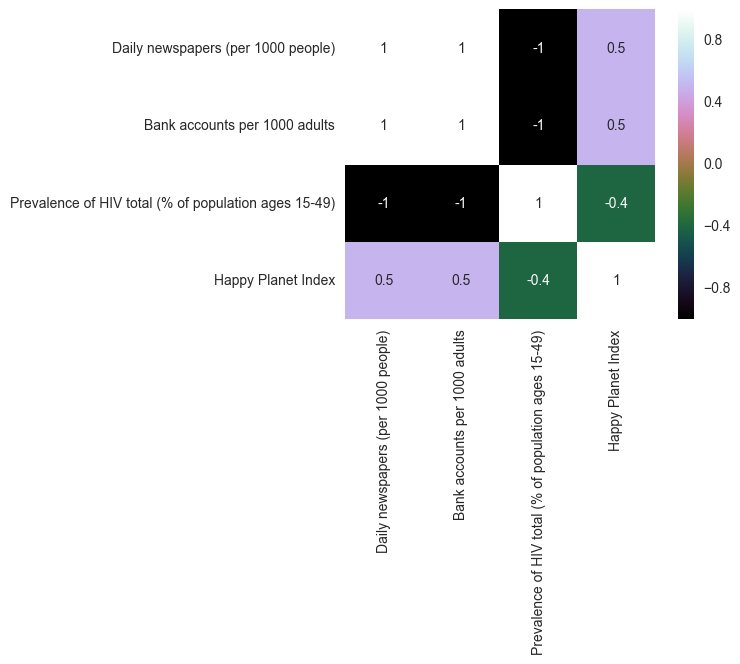

In [255]:
corr_features = ['Daily newspapers (per 1000 people)', 'Bank accounts per 1000 adults',\
                         'Prevalence of HIV total (% of population ages 15-49)', 'Happy Planet Index']
overall_data_to_plot = overall_data[corr_features]
data_corr_mat= overall_data_to_plot.corr(method='spearman')
c = data_corr_mat.corr(method='spearman')
sns.heatmap(c, vmax=1, square=True, annot=True, cmap='cubehelix')

## Plotting the Happy Planet Index over the globe

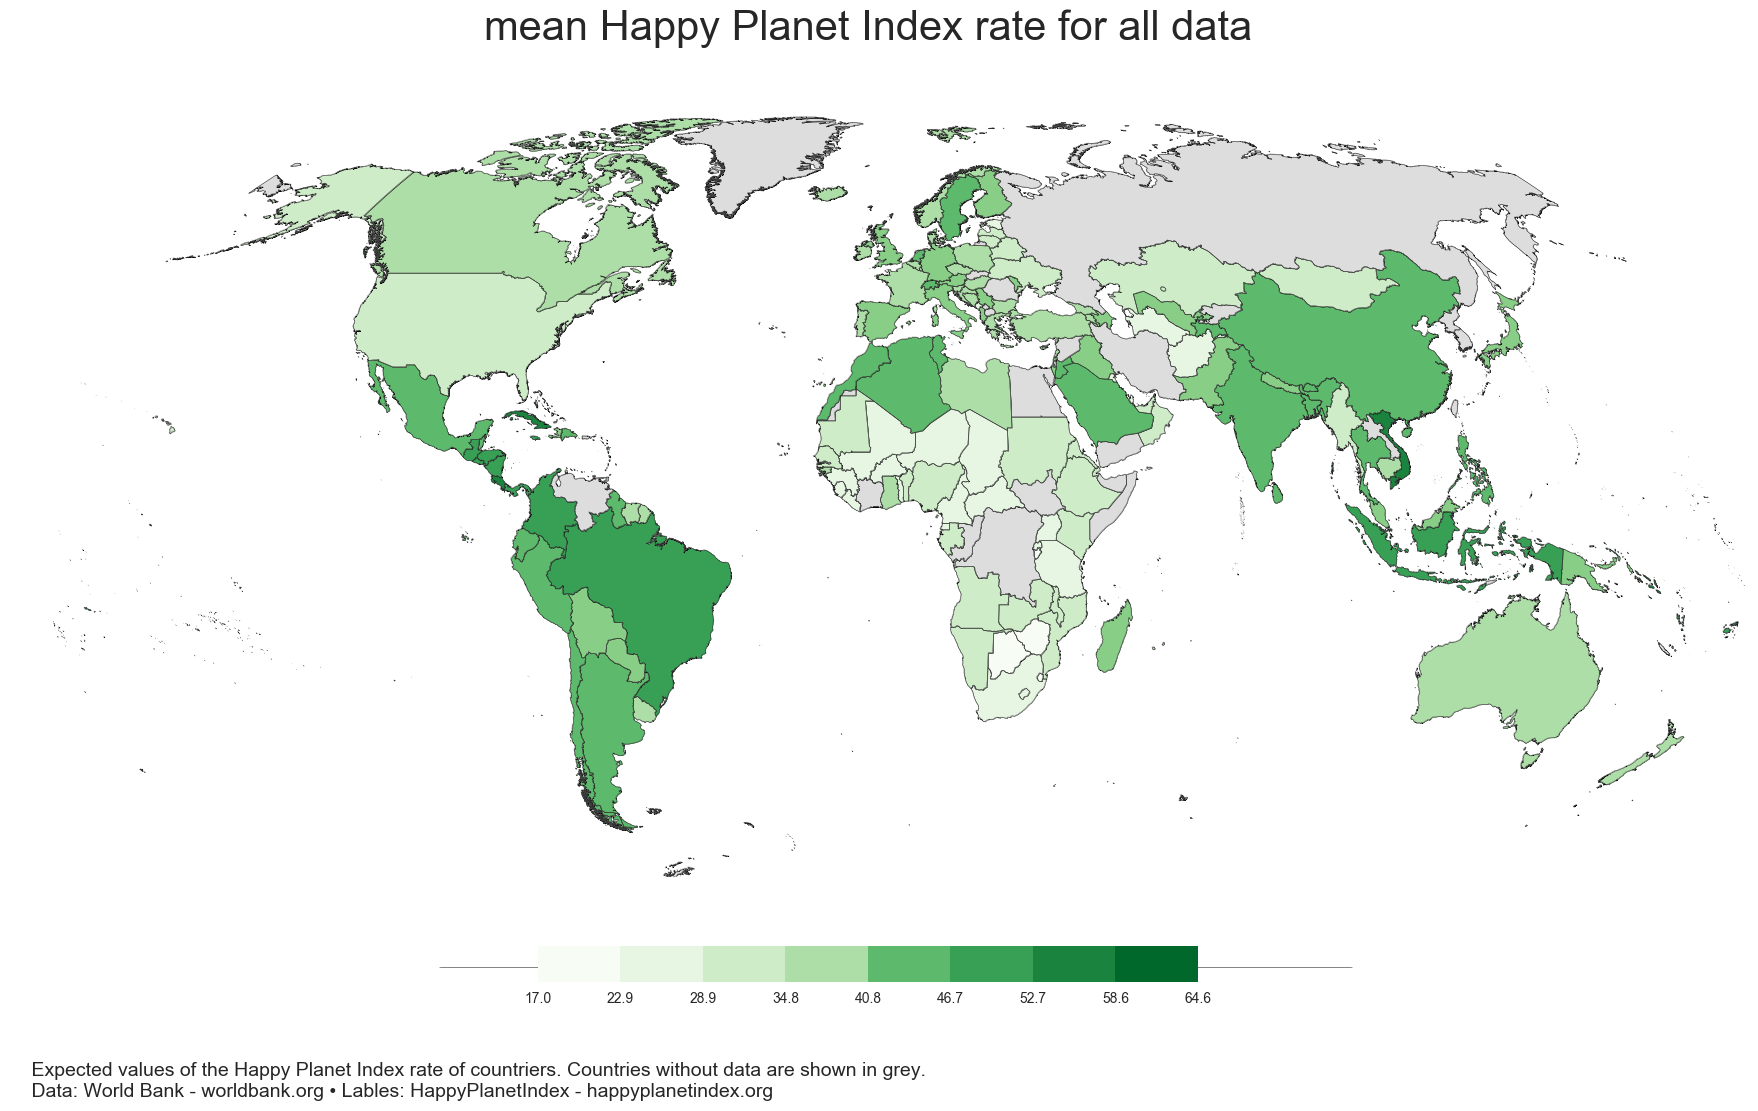

In [256]:
plotDataOnMap(overall_data, feature='Happy Planet Index', year='mean')

## Plotting the Daily newspapers (per 1000 people) over the globe

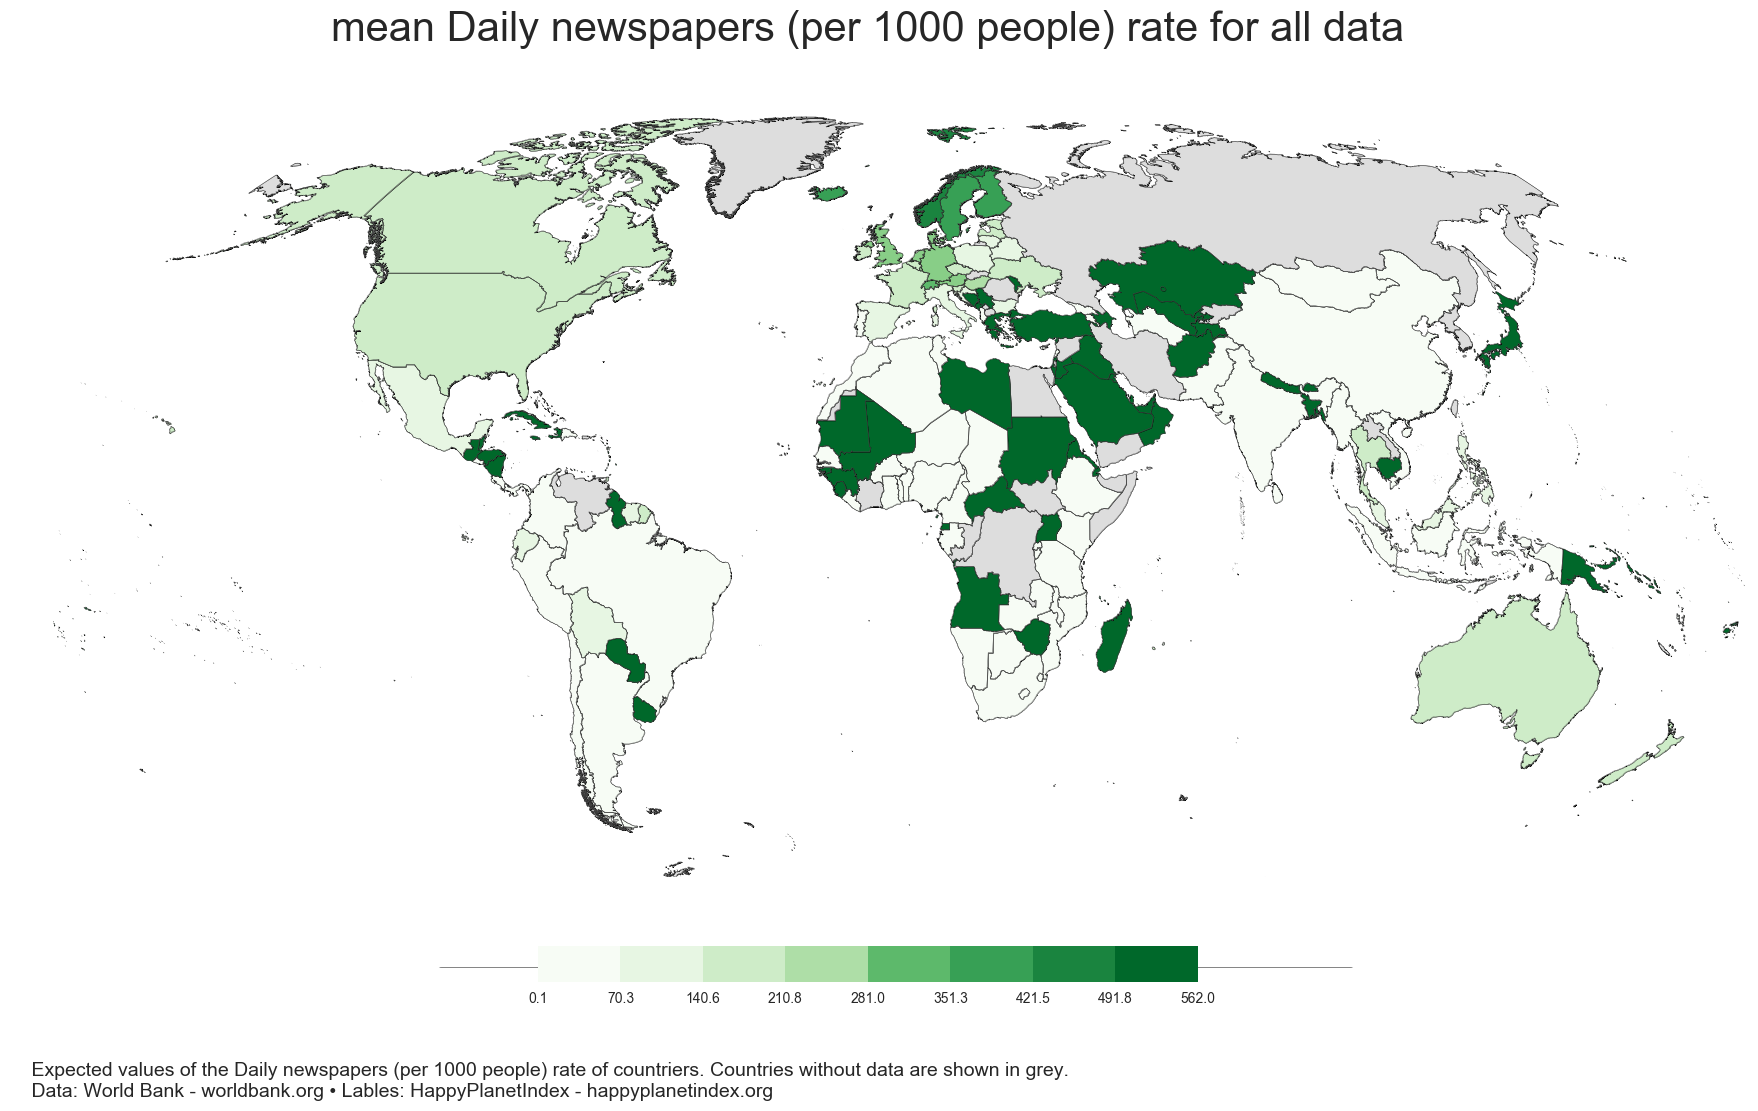

In [257]:
plotDataOnMap(overall_data, feature='Daily newspapers (per 1000 people)', year='mean')

### Which Countries doesn't corrolate in Daily newspapers feature and target

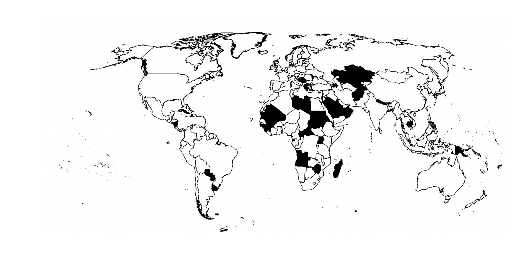

In [258]:
feature_image = globe_plots + 'Happy Planet Index_2012.png'
target_image = globe_plots + 'Daily newspapers (per 1000 people)_mean.png'
output_image = uncorrolated_plots + 'Daily_newspapers.png'
plotUncorrolatedCountries(feature_image, target_image, output_image)

## Plotting the Bank accounts per 1000 adults over the globe

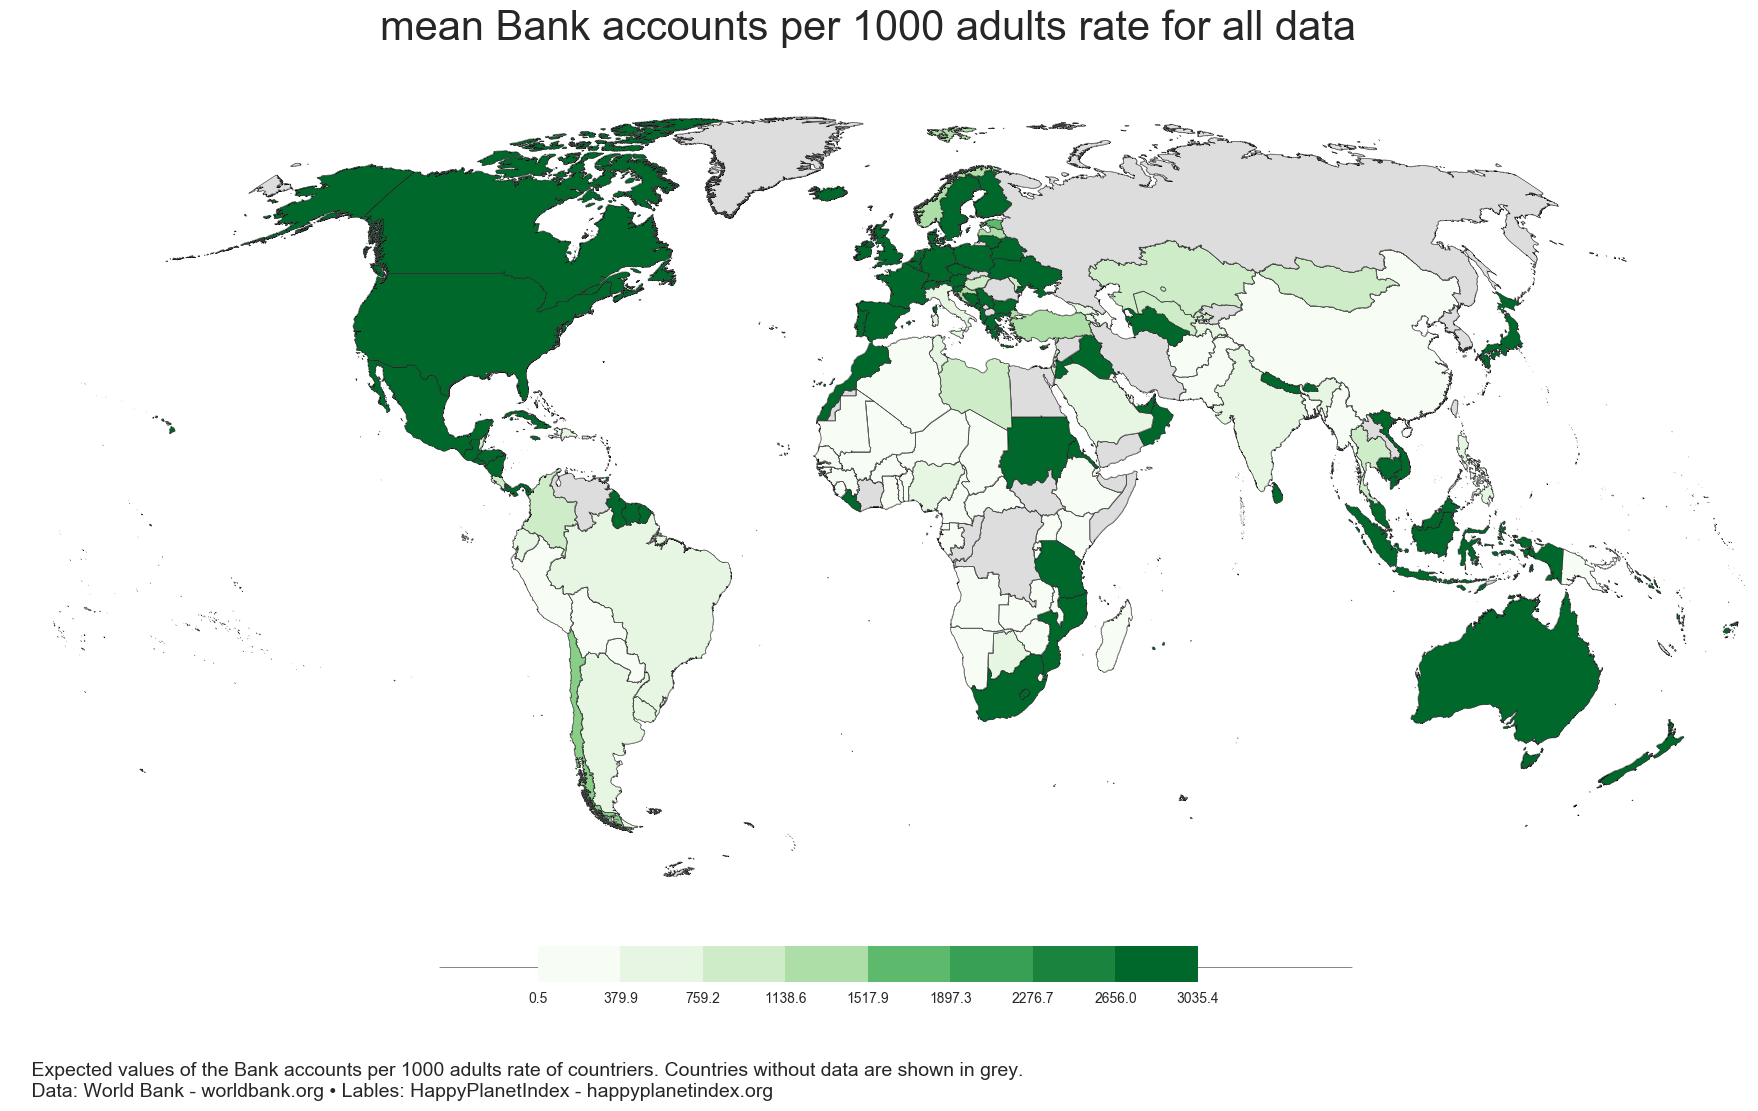

In [259]:
plotDataOnMap(overall_data, feature='Bank accounts per 1000 adults', year='mean')

### Which Countries doesn't corrolate in Bank accounts feature and target

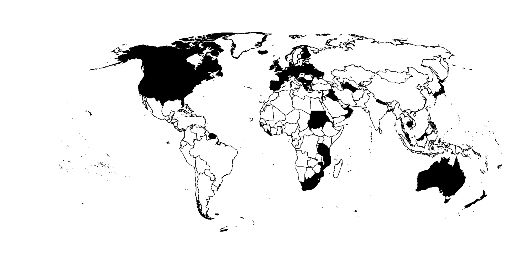

In [260]:
feature_image = globe_plots + 'Happy Planet Index_mean.png'
target_image = globe_plots + 'Bank accounts per 1000 adults_mean.png'
output_image = uncorrolated_plots + 'Bank_accounts.png'
plotUncorrolatedCountries(feature_image, target_image, output_image)

## Plotting the Prevalence of HIV total (% of population ages 15-49) over the globe

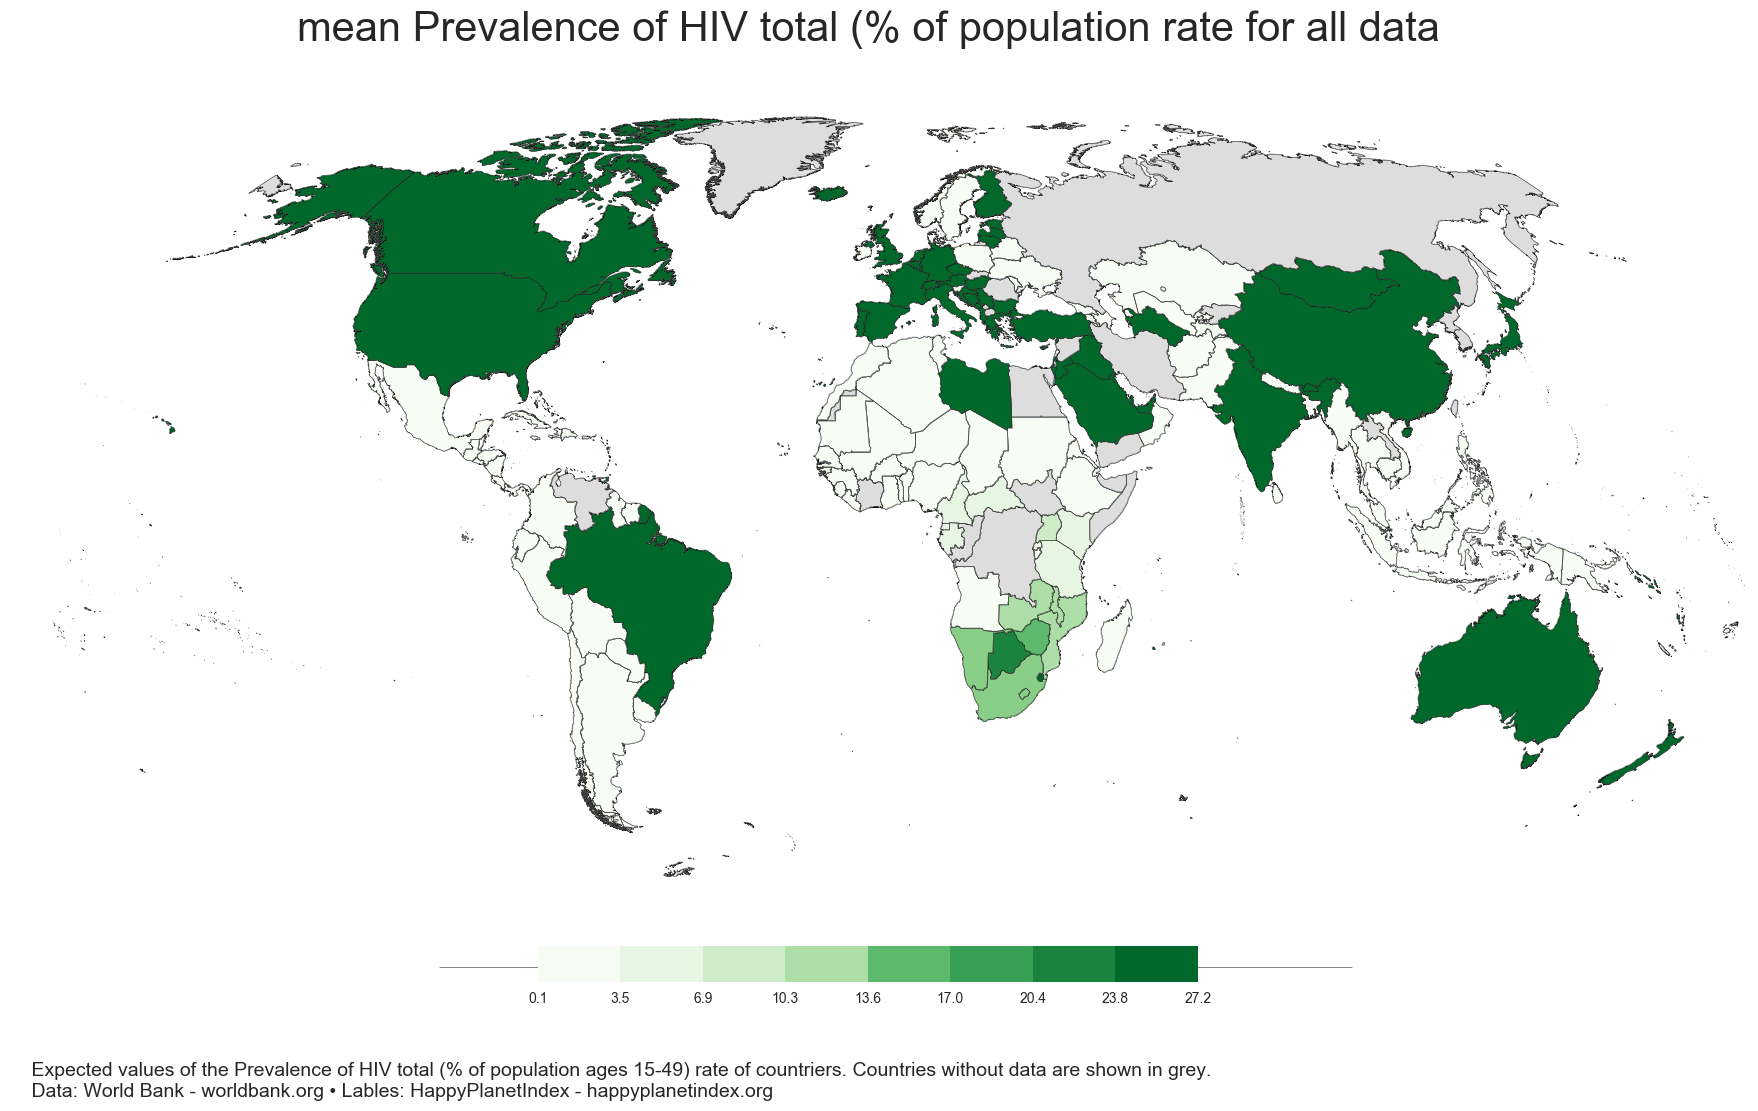

In [261]:
plotDataOnMap(overall_data, feature='Prevalence of HIV total (% of population ages 15-49)', year='mean')

### Which Countries doesn't corrolate in Prevalence of HIV feature and target

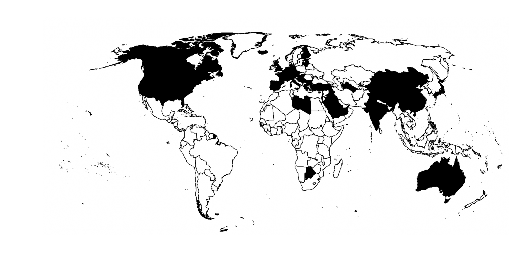

In [262]:
feature_image = globe_plots + 'Happy Planet Index_2012.png'
target_image = globe_plots + 'Prevalence of HIV total (% of population ages 15-49)_mean.png'
output_image = uncorrolated_plots + 'Prevalence_of_HIV_total.png'
plotUncorrolatedCountries(feature_image, target_image, output_image)

### We can see same countries uncorrolated for same features

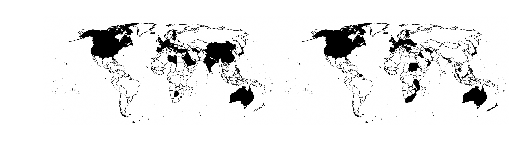

(<matplotlib.image.AxesImage at 0x1da2e7b2748>, None)

In [286]:
def concatImages(imga, imgb):
    """
    Combines two color image ndarrays side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    total_width = wa+wb
    new_img = np.zeros(shape=(max_height, total_width), dtype=np.uint8)
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    return new_img

im1 = plt.imread(uncorrolated_plots + 'Prevalence_of_HIV_total.png')
im2 = plt.imread(uncorrolated_plots + 'Bank_accounts.png')
out = concatImages(im1, im2)
plt.axis('off')
plt.imshow(out, cmap = 'gray', interpolation = 'bicubic'),plt.show()

### Impute nulls with medians

In [271]:
overall_data = overall_data.fillna(overall_data.median())
overall_data.head(5)

country    year  Access to electricity (% of population)  \
0  Afghanistan  2012.0                                     43.0   
1  Afghanistan  2016.0                                     43.0   
2      Albania  2006.0                                     99.7   
3      Albania  2006.0                                     99.7   
4      Albania  2009.0                                     99.7   

   Adolescent fertility rate (births per 1000 women ages 15-19)  \
0                                              87.79              
1                                              76.73              
2                                              18.73              
3                                              20.92              
4                                              19.48              

   Age dependency ratio (% of working-age population)  \
0                                              95.31    
1                                              89.77    
2                                              52.15    
3                                              51.26    
4                                              48.64    

   Agriculture value added (% of GDP)  \
0                               24.60   
1                               23.97   
2                               22.00   
3                                4.60   
4                               19.41   

   Agriculture value added (annual % growth)  \
0                                      18.22   
1                                       1.90   
2                                       3.10   
3                                       2.30   
4                                       1.90   

   Agriculture value added (constant 2005 US$)  \
0                                 2.645462e+09   
1                                 2.689738e+09   
2                                 1.693547e+09   
3                                 3.860272e+09   
4                                 1.897705e+09   

   Agriculture value added per worker (constant 2005 US$)  \
0                                            413.030        
1                                            395.780        
2                                           2696.730        
3                                           7712.345        
4                                           3065.760        

   Air transport registered carrier departures worldwide         ...          \
0                                           17775.00             ...           
1                                           25389.38             ...           
2                                            4481.00             ...           
3                                           93600.00             ...           
4                                            5140.00             ...           

   Stock market capitalization to GDP (%)  \
0                                  43.185   
1                                  43.185   
2                                  43.185   
3                                  43.185   
4                                  43.185   

   Stock market return (% year-on-year)  \
0                                  4.43   
1                                  4.43   
2                                  4.43   
3                                  4.43   
4                                  4.43   

   Stock market total value traded to GDP (%)  \
0                                       13.19   
1                                       13.19   
2                                       13.19   
3                                       13.19   
4                                       13.19   

   Stock market turnover ratio (%)  Stock price volatility  \
0                            35.97                  18.815   
1                            35.97                  18.815   
2                            35.97                  18.815   
3                            35.97                  18.815   
4                            35.97    

## One Hot Encoding Foreach Country

In [272]:
oh_overall_data=overall_data.drop('country',axis=1)
onehot_overall_col = pd.get_dummies(overall_data['country'], prefix='country')

#check for missing cols in onehot_overall_col
for col in onehot_overall_col.columns:
    if col not in onehot_overall_col.columns:
        onehot_overall_col[col]=0
        
oh_overall_data = pd.concat([oh_overall_data, onehot_overall_col], axis=1)
overall_data = oh_overall_data
overall_data.head(5)

year  Access to electricity (% of population)  \
0  2012.0                                     43.0   
1  2016.0                                     43.0   
2  2006.0                                     99.7   
3  2006.0                                     99.7   
4  2009.0                                     99.7   

   Adolescent fertility rate (births per 1000 women ages 15-19)  \
0                                              87.79              
1                                              76.73              
2                                              18.73              
3                                              20.92              
4                                              19.48              

   Age dependency ratio (% of working-age population)  \
0                                              95.31    
1                                              89.77    
2                                              52.15    
3                                              51.26    
4                                              48.64    

   Agriculture value added (% of GDP)  \
0                               24.60   
1                               23.97   
2                               22.00   
3                                4.60   
4                               19.41   

   Agriculture value added (annual % growth)  \
0                                      18.22   
1                                       1.90   
2                                       3.10   
3                                       2.30   
4                                       1.90   

   Agriculture value added (constant 2005 US$)  \
0                                 2.645462e+09   
1                                 2.689738e+09   
2                                 1.693547e+09   
3                                 3.860272e+09   
4                                 1.897705e+09   

   Agriculture value added per worker (constant 2005 US$)  \
0                                            413.030        
1                                            395.780        
2                                           2696.730        
3                                           7712.345        
4                                           3065.760        

   Air transport registered carrier departures worldwide  \
0                                           17775.00       
1                                           25389.38       
2                                            4481.00       
3                                           93600.00       
4                                            5140.00       

   CPIA economic management cluster average (1=low to 6=high)  \
0                                               3.00            
1                                               3.00            
2                                               4.00            
3                                               3.67            
4                                               3.67            

         ...         country_Ukraine  country_United Arab Emirates  \
0        ...                     0.0                           0.0   
1        ...                     0.0                           0.0   
2        ...                     0.0                           0.0   
3        ...                     0.0                           0.0   
4        ...                     0.0                           0.0   

   country_United Kingdom  country_United States  country_Uruguay  \
0                     0.0                    0.0              0.0   
1                     0.0                    0.0              0.0   
2                     0.0                    0.0              0.0   
3                     0.0                    0.0              0.0   
4                     0.0                    0.0              0.0   

   country_Uzbekistan  country_Vanuatu  country_Vietnam  country_Zambia  \
0                 0.0              0.0              0.0            

### Change all values' datatypes to float

In [273]:
for variable in overall_data.columns:
    overall_data[variable] = overall_data[variable].astype(np.float)
overall_data.dtypes

year                                                                                                      float64
Access to electricity (% of population)                                                                   float64
Adolescent fertility rate (births per 1000 women ages 15-19)                                              float64
Age dependency ratio (% of working-age population)                                                        float64
Agriculture value added (% of GDP)                                                                        float64
Agriculture value added (annual % growth)                                                                 float64
Agriculture value added (constant 2005 US$)                                                               float64
Agriculture value added per worker (constant 2005 US$)                                                    float64
Air transport registered carrier departures worldwide                                   

## Split Data into training set and test set

In [274]:
def splitToTrainAndTest(df):
    msk = np.random.rand(len(df)) < 0.8
    train = df[msk]
    train.reset_index(drop=True, inplace=True)
    test = df[~msk]
    test.reset_index(drop=True, inplace=True)
    train.to_csv(path_train)
    test.to_csv(path_test)

splitToTrainAndTest(overall_data)
train_data = pd.read_csv(path_train, header=0, index_col=0, skiprows=0, encoding='iso-8859-1')
test_data = pd.read_csv(path_test, header=0, index_col=0, skiprows=0, encoding='iso-8859-1')
train_data.head(5)

year  Access to electricity (% of population)  \
0  2012.0                                     43.0   
1  2006.0                                     99.7   
2  2006.0                                     99.7   
3  2012.0                                    100.0   
4  2012.0                                     99.7   

   Adolescent fertility rate (births per 1000 women ages 15-19)  \
0                                              87.79              
1                                              18.73              
2                                              20.92              
3                                              20.80              
4                                              20.92              

   Age dependency ratio (% of working-age population)  \
0                                              95.31    
1                                              52.15    
2                                              51.26    
3                                              45.84    
4                                              51.26    

   Agriculture value added (% of GDP)  \
0                               24.60   
1                               22.00   
2                                4.60   
3                               21.83   
4                                4.60   

   Agriculture value added (annual % growth)  \
0                                      18.22   
1                                       3.10   
2                                       2.30   
3                                       5.41   
4                                       2.30   

   Agriculture value added (constant 2005 US$)  \
0                                 2.645462e+09   
1                                 1.693547e+09   
2                                 3.860272e+09   
3                                 2.256162e+09   
4                                 3.860272e+09   

   Agriculture value added per worker (constant 2005 US$)  \
0                                            413.030        
1                                           2696.730        
2                                           7712.345        
3                                           3735.370        
4                                           7712.345        

   Air transport registered carrier departures worldwide  \
0                                           17775.00       
1                                            4481.00       
2                                           93600.00       
3                                           10309.18       
4                                           93600.00       

   CPIA economic management cluster average (1=low to 6=high)  \
0                                               3.00            
1                                               4.00            
2                                               3.67            
3                                               3.67            
4                                               3.67            

         ...         country_Ukraine  country_United Arab Emirates  \
0        ...                     0.0                           0.0   
1        ...                     0.0                           0.0   
2        ...                     0.0                           0.0   
3        ...                     0.0                           0.0   
4        ...                     0.0                           0.0   

   country_United Kingdom  country_United States  country_Uruguay  \
0                     0.0                    0.0              0.0   
1                     0.0                    0.0              0.0   
2                     0.0                    0.0              0.0   
3                     0.0                    0.0              0.0   
4                     0.0                    0.0              0.0   

   country_Uzbekistan  country_Vanuatu  country_Vietnam  country_Zambia  \
0                 0.0              0.0              0.0            

### Partition to factors and class

In [275]:
train_class = train_data['Happy Planet Index']
train_factors =(train_data.drop('Happy Planet Index', axis=1))

test_class = test_data['Happy Planet Index']
test_factors =(test_data.drop('Happy Planet Index', axis=1))
train_class.head(5)

0    36.8
1    42.1
2    42.1
3    54.1
4    54.1
Name: Happy Planet Index, dtype: float64

## Binning The Years by Decades

In [276]:
#binning the years train
min_year = min(min(train_factors['year']), min(test_factors['year']))

def decade(year):
    return(math.floor((year-min_year) / 10))

for row in range(train_factors.shape[0]):
    val=train_factors.at[row, 'year']
    new_val=decade(val)
    train_factors.set_value(row, 'year', new_val)
    
#binning the years test

for row in range(test_factors.shape[0]):
    val=test_factors.at[row, 'year']
    new_val=decade(val)
    test_factors.set_value(row, 'year', new_val)
train_factors.head(5)

year  Access to electricity (% of population)  \
0   2.0                                     43.0   
1   1.0                                     99.7   
2   1.0                                     99.7   
3   2.0                                    100.0   
4   2.0                                     99.7   

   Adolescent fertility rate (births per 1000 women ages 15-19)  \
0                                              87.79              
1                                              18.73              
2                                              20.92              
3                                              20.80              
4                                              20.92              

   Age dependency ratio (% of working-age population)  \
0                                              95.31    
1                                              52.15    
2                                              51.26    
3                                              45.84    
4                                              51.26    

   Agriculture value added (% of GDP)  \
0                               24.60   
1                               22.00   
2                                4.60   
3                               21.83   
4                                4.60   

   Agriculture value added (annual % growth)  \
0                                      18.22   
1                                       3.10   
2                                       2.30   
3                                       5.41   
4                                       2.30   

   Agriculture value added (constant 2005 US$)  \
0                                 2.645462e+09   
1                                 1.693547e+09   
2                                 3.860272e+09   
3                                 2.256162e+09   
4                                 3.860272e+09   

   Agriculture value added per worker (constant 2005 US$)  \
0                                            413.030        
1                                           2696.730        
2                                           7712.345        
3                                           3735.370        
4                                           7712.345        

   Air transport registered carrier departures worldwide  \
0                                           17775.00       
1                                            4481.00       
2                                           93600.00       
3                                           10309.18       
4                                           93600.00       

   CPIA economic management cluster average (1=low to 6=high)  \
0                                               3.00            
1                                               4.00            
2                                               3.67            
3                                               3.67            
4                                               3.67            

         ...         country_Ukraine  country_United Arab Emirates  \
0        ...                     0.0                           0.0   
1        ...                     0.0                           0.0   
2        ...                     0.0                           0.0   
3        ...                     0.0                           0.0   
4        ...                     0.0                           0.0   

   country_United Kingdom  country_United States  country_Uruguay  \
0                     0.0                    0.0              0.0   
1                     0.0                    0.0              0.0   
2                     0.0                    0.0              0.0   
3                     0.0                    0.0              0.0   
4                     0.0                    0.0              0.0   

   country_Uzbekistan  country_Vanuatu  country_Vietnam  country_Zambia  \
0                 0.0              0.0              0.0             0.0   
1 

## Centering and Scaling

In [278]:
#train
for col in train_factors.columns:
    mean = train_factors[col].mean()
    std = train_factors[col].std()
    for row in range(train_factors.shape[0]):
        train_factors.set_value(row, col, (train_factors.at[row, col] - mean) / std)
class_mean=train_class.mean()
for row in range(train_factors.shape[0]):
    train_class.set_value(row, train_class[row] - class_mean)

#test
for col in test_factors.columns:
    mean = test_factors[col].mean()
    std = test_factors[col].std()
    for row in range(test_factors.shape[0]):
        test_factors.set_value(row, col, (test_factors.at[row, col] - mean) / std)
class_mean = test_class.mean()
for row in range(test_factors.shape[0]):
    test_class.set_value(row, test_class[row] - class_mean)

train_factors.head(5)

year  Access to electricity (% of population)  \
0  1.402509                                -3.417061   
1  0.020326                                 0.262622   
2  0.020326                                 0.262622   
3  1.402509                                 0.282091   
4  1.402509                                 0.262622   

   Adolescent fertility rate (births per 1000 women ages 15-19)  \
0                                           1.533988              
1                                          -0.434307              
2                                          -0.371889              
3                                          -0.375309              
4                                          -0.371889              

   Age dependency ratio (% of working-age population)  \
0                                           3.022111    
1                                          -0.215721    
2                                          -0.282489    
3                                          -0.689093    
4                                          -0.282489    

   Agriculture value added (% of GDP)  \
0                            1.782010   
1                            1.503723   
2                           -0.358663   
3                            1.485527   
4                           -0.358663   

   Agriculture value added (annual % growth)  \
0                                   2.391598   
1                                   0.167490   
2                                   0.049812   
3                                   0.507284   
4                                   0.049812   

   Agriculture value added (constant 2005 US$)  \
0                                    -0.287604   
1                                    -0.319750   
2                                    -0.246579   
3                                    -0.300750   
4                                    -0.246579   

   Agriculture value added per worker (constant 2005 US$)  \
0                                          -0.807451        
1                                          -0.670777        
2                                          -0.370604        
3                                          -0.608616        
4                                          -0.370604        

   Air transport registered carrier departures worldwide  \
0                                          -0.346885       
1                                          -0.373458       
2                                          -0.195321       
3                                          -0.361808       
4                                          -0.195321       

   CPIA economic management cluster average (1=low to 6=high)  \
0                                          -2.450576            
1                                           1.237122            
2                                           0.020182            
3                                           0.020182            
4                                           0.020182            

         ...         country_Ukraine  country_United Arab Emirates  \
0        ...               -0.079598                     -0.056195   
1        ...               -0.079598                     -0.056195   
2        ...               -0.079598                     -0.056195   
3        ...               -0.079598                     -0.056195   
4        ...               -0.079598                     -0.056195   

   country_United Kingdom  country_United States  country_Uruguay  \
0               -0.173986              -0.056195        -0.056195   
1               -0.173986              -0.056195        -0.056195   
2               -0.173986              -0.056195        -0.056195   
3               -0.173986              -0.056195        -0.056195   
4               -0.173986              -0.056195        -0.056195   

   country_Uzbekistan  country_Vanuatu  country_Vietnam  country_Zambia  \
0           -0.064923        -0.045859        -0.056195  